In this notebook we build a deconvolving autoencoder in PyTorch. We've generated the convolved samples already in simulate-faraday-screens so we just need a regular autoencoder now.

In [2]:
from pathlib import Path

import numpy, matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [3]:
jack_path = Path(
    '/home/alger/possum/livingston/stokes_data_collection/'
    'galactic_centre/')

In [4]:
spectra = numpy.load('simulated-spectra.npy')
spectra_gt = numpy.load('simulated-spectra-gt.npy')

In [5]:
spectra_real = numpy.transpose(numpy.stack(
    [spectra.real, spectra.imag]), (1, 0, 2))
spectra_gt_real = numpy.transpose(numpy.stack(
    [spectra_gt.real, spectra_gt.imag]), (1, 0, 2))
spectra_real.shape

(10000, 2, 1000)

In [7]:
import torch
from torch import nn, optim

In [44]:
torch_spectra = torch.from_numpy(
    spectra_real / spectra_real.max(axis=0))[:15]
torch_spectra_gt = torch.from_numpy(
    spectra_gt_real / spectra_gt_real.max(axis=0))[:15]
torch_spectra.shape

torch.Size([15, 2, 1000])

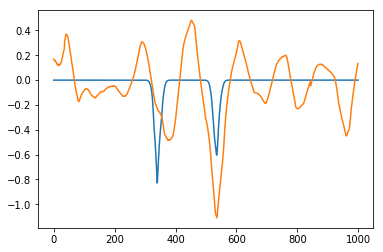

In [45]:
%matplotlib inline
plt.plot(torch_spectra_gt[0].numpy()[0])
plt.plot(torch_spectra[0].numpy()[0])

In [46]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

class AE(nn.Module):
    def __init__(self, input_size, hidden_sizes, kernel_size=5):
        super().__init__()
        self.input_size = self.n = n = input_size
        self.hidden_size = self.h = h = hidden_sizes
        self.kernel_size = kernel_size
        self.encode = nn.Sequential(
            nn.Conv1d(2, h[0], 5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(h[0], h[1], 5, padding=2),
            nn.LeakyReLU(),
            nn.Conv1d(h[1], h[2], 5, padding=2),
            nn.LeakyReLU(),
            Reshape(-1, n * h[2]),
            nn.Linear(n * h[2], h[3]),
        )
        self.decode = nn.Sequential(
            nn.Linear(h[3], n * h[2]),
            Reshape(-1, h[2], n),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(h[2], h[1], kernel_size, padding=kernel_size // 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(h[1], h[0], kernel_size, padding=kernel_size // 2),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(h[0], 2, kernel_size, padding=kernel_size // 2),
            nn.Tanh(),
        )
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [65]:
ae = AE(spectra_real.shape[2], [128, 64, 32, 16], kernel_size=3).double()
optimiser = optim.Adagrad(ae.parameters(), lr=1e-3)
ae(torch_spectra[:10]).shape

ae.load_state_dict(torch.load('dcae.model', map_location='cpu'), strict=False)

<IPython.core.display.Javascript object>


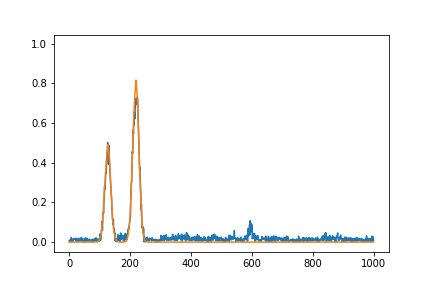

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


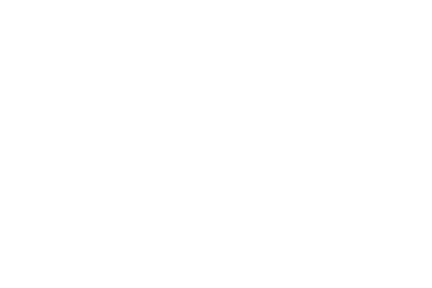

In [52]:
def make_recon(recon):
    recon = recon.detach().numpy()
    return numpy.sqrt(recon[0] **2 + recon[1] ** 2)

%matplotlib notebook
n_epochs = 1000
losses = []
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
recon_plot, = ax.plot(range(spectra.shape[1]),
                      make_recon(ae(torch_spectra[:1])[0]))
gt_plot, = ax.plot(make_recon(torch_spectra_gt[0]))
loss_fn = nn.MSELoss()
bar = tqdm(total=n_epochs)
shuffle_indices = numpy.arange(len(torch_spectra))
for epoch in range(n_epochs):
    numpy.random.shuffle(shuffle_indices)
    torch_spectra_ = torch_spectra[shuffle_indices]
    torch_spectra_gt_ = torch_spectra_gt[shuffle_indices]
    ae.zero_grad()
    recon = ae(torch_spectra_)
    loss = loss_fn(recon, torch_spectra_gt_)
    loss.backward()
    optimiser.step()
    recon_plot.set_ydata(make_recon(recon[0]))
    gt_plot.set_ydata(make_recon(torch_spectra_gt_[0]))
    fig.canvas.draw()
    bar.postfix = '{:.4e}'.format(loss.item())
    bar.update(1)

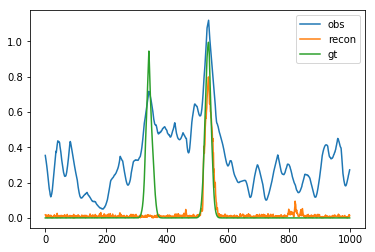

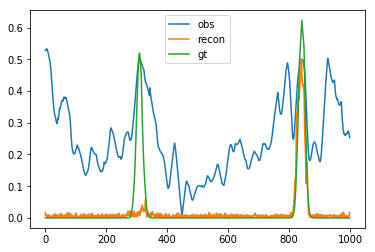

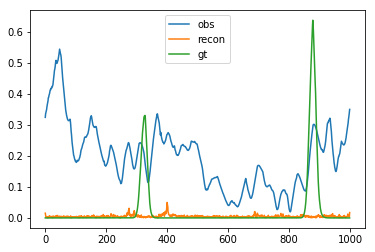

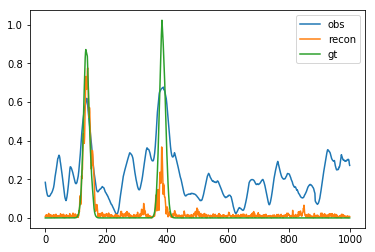

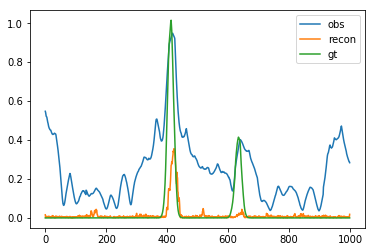

In [66]:
%matplotlib inline
for i in range(5):
    i = i
    plt.plot(make_recon(torch_spectra[i:i+1][0]), label='obs')
    plt.plot(make_recon(ae(torch_spectra[i:i+1])[0]), label='recon')
    plt.plot(make_recon(torch_spectra_gt[i]), label='gt')
    plt.legend()
    plt.show()

/home/alger/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


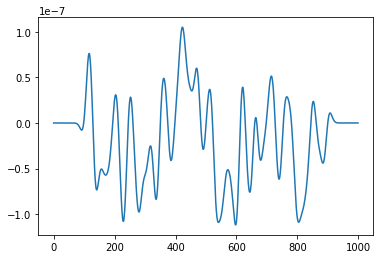

In [60]:
plt.plot(numpy.mean(spectra_gt, axis=0))

In [14]:
phi, rmsf = numpy.loadtxt('rmsf.txt', dtype=complex).T

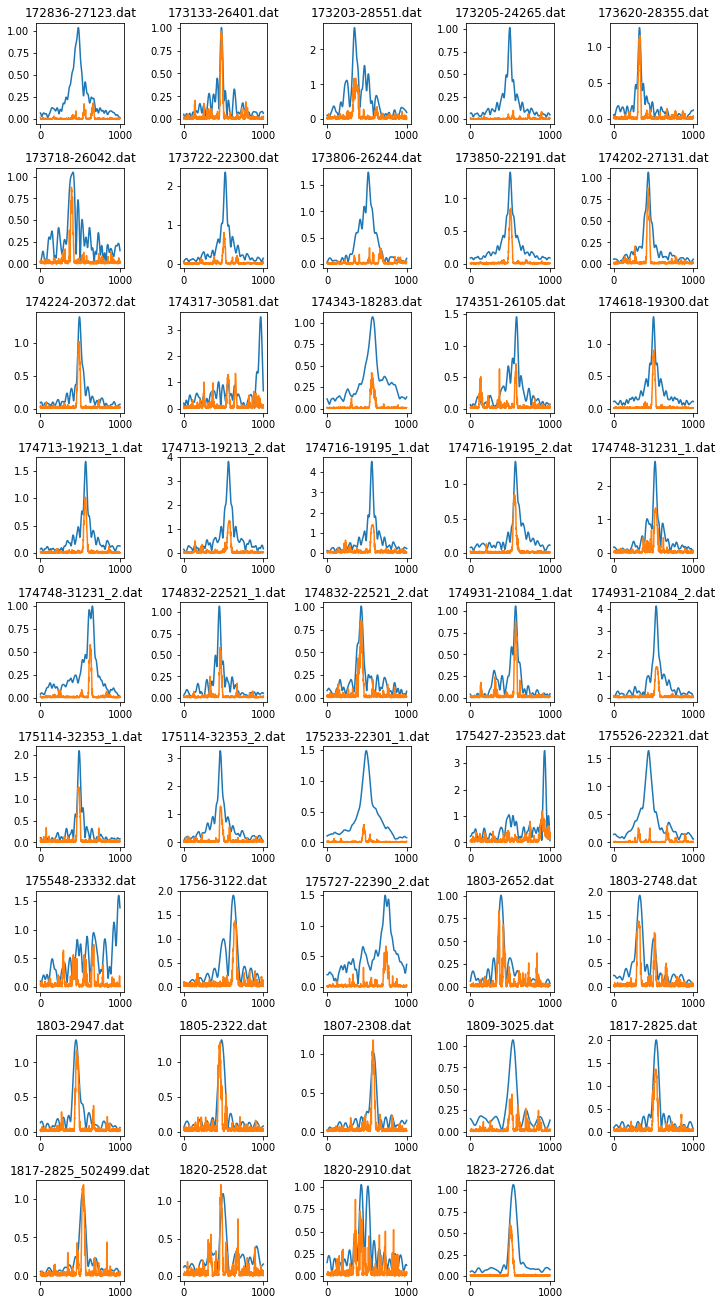

In [67]:
%matplotlib inline
plt.figure(figsize=(10, 20))
for i in range(44):
    path = sorted(jack_path.iterdir())[i]
    plt.subplot(10, 5, i + 1)
    data = numpy.load('fdf_{}.npy'.format(i))
    data = data.reshape((1,) + data.shape)
    data = numpy.transpose(numpy.stack(
        [data.real, data.imag]), (1, 0, 2))
    data = torch.from_numpy(data)
    data /= data.max()
    plt.plot(make_recon(data[0]), label='obs')
    plt.plot(make_recon(ae(data)[0]), label='recon')
    plt.title(path.name)
plt.tight_layout()

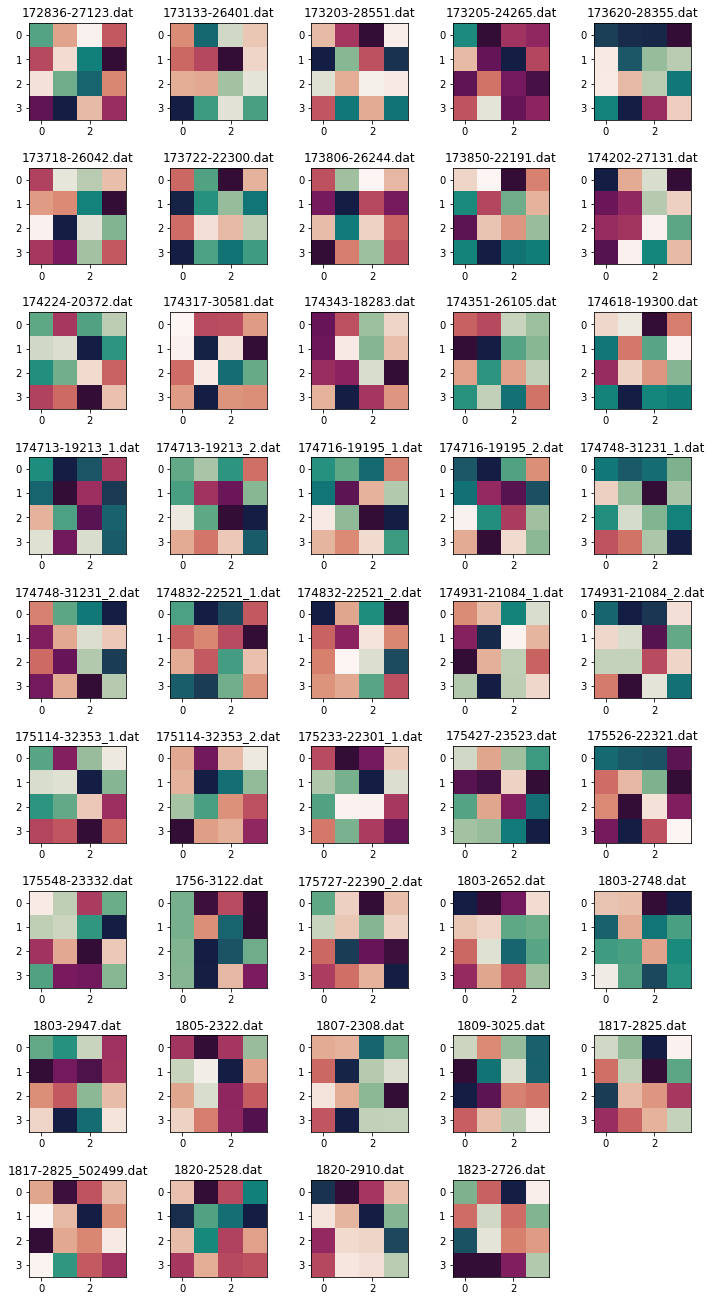

In [85]:
from cmocean import cm
encodings = []
%matplotlib inline
plt.figure(figsize=(10, 20))
for i in range(44):
    path = sorted(jack_path.iterdir())[i]
    plt.subplot(10, 5, i + 1)
    data = numpy.load('fdf_{}.npy'.format(i))
    data = data.reshape((1,) + data.shape)
    data = numpy.transpose(numpy.stack(
        [data.real, data.imag]), (1, 0, 2))
    data = torch.from_numpy(data)
    data /= data.max()
    encoding = ae.encode(data).detach().numpy()
    encodings.append(encoding)
    plt.imshow(encoding.reshape(4, 4), cmap=cm.curl)
    plt.title(path.name)
plt.tight_layout()

In [87]:
encodings = numpy.array(encodings)

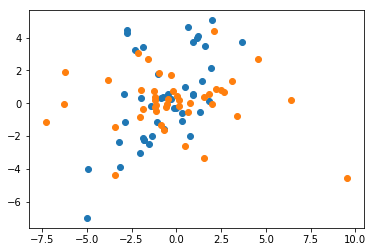

In [93]:
plt.scatter(encodings[:, 0, 0], encodings[:, 0, 1])

In [90]:
encodings.shape

(44, 1, 16)